# Imports

In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Model

2022-12-06 11:34:55.001444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 11:34:55.001457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Paths and key frames

In [16]:
# Paths

rel_imagedir_path = '../../../data/screenshots/'
legit_image_path = os.path.join(rel_imagedir_path, 'legit_screenshots')
scam_image_path = os.path.join(rel_imagedir_path, 'scam_screenshots')

In [3]:
legit_image_path, scam_image_path

('../../../data/screenshots/legit_screenshots',
 '../../../data/screenshots/scam_screenshots')

In [4]:
# Legit websites

legit_key_df = pd.read_csv('legim_text_screenshots_key.csv')
print(legit_key_df.shape)

(2189, 5)


In [5]:
legit_key_df = legit_key_df.drop(columns=['Unnamed: 0', 'index'])
legit_key_df['target'] = 0
legit_key_df = legit_key_df.drop_duplicates(subset='url')
legit_key_df

,url,num_of_picture,text,target
0,http://www.theaccessbankukltd.co.uk,0,menuaboutpersonalbusinessprivatedubainewsconta...,0
1,http://www.adambank.com,1,transfer contact usloginon 3 september 2022 we...,0
2,http://www.adib.co.uk,2,sign in​homeabout adibour brandmission objec...,0
3,http://www.aldermore.co.uk,3,log inpersonalbusinessintermediariesabout usco...,0
4,http://www.allfunds.com/en,4,cookie configurationallfunds bank s a u allf...,0
...,...,...,...,...
2184,http://www.roberthalf.com/,2104,this website uses cookies to improve user expe...,0
2185,http://www.compass-group.com/,2105,our use of cookieswe use necessary cookies to ...,0
2186,http://shop.hasbro.com/,2106,skip to main contentnl nederlandsontdek spee...,0
2187,http://www.ropertech.com/,2107,skip to content↵enterskip to contentsimple ide...,0


In [6]:
# Scam websites

scam_key_df = pd.read_csv('scam_text_screenshots_key.csv')
scam_key_df = scam_key_df.drop(columns=['Unnamed: 0'])
scam_key_df['target'] = 1
scam_key_df

,url,num_of_picture,text,target
0,https://www.awesomeaussieshepherd.com,0,australian shepherd homeabout usavailable pup...,1
1,http://www.gclservice.co.za,1,index of \tname\tlast modified\tsize\tdescri...,1
2,https://www.gcloanservice.com,2,menuhomeloan applicationcontact usfaqsterms of...,1
3,http://www.authenicbiodocs.com,3,skip to contentpay with bitcoin25 discount fo...,1
4,https://www.thaiproductsllc.com,4,skip to content 61 3 9028 2716world wide shipp...,1
...,...,...,...,...
2029,https://www.reynoldsfinance.com,2175,reynoldsfinance comhomecontact usprivacy polic...,1
2030,https://www.heartfordcapital.com,2176,live chat 1 614 655 7713trade shares and forex...,1
2031,https://www.e1am.com,2177,skip to main contentlogin by your side for m...,1
2032,https://www.blackwellcapital.com,2178,blackwell capital 800 917 7155homelendinginv...,1


In [7]:
merged_key_df = pd.concat([legit_key_df, scam_key_df], ignore_index=True).reset_index(drop=True)
# merged_key_df = merged_key_df.sample(frac=1)

In [8]:
merged_key_df

,url,num_of_picture,text,target
0,http://www.theaccessbankukltd.co.uk,0,menuaboutpersonalbusinessprivatedubainewsconta...,0
1,http://www.adambank.com,1,transfer contact usloginon 3 september 2022 we...,0
2,http://www.adib.co.uk,2,sign in​homeabout adibour brandmission objec...,0
3,http://www.aldermore.co.uk,3,log inpersonalbusinessintermediariesabout usco...,0
4,http://www.allfunds.com/en,4,cookie configurationallfunds bank s a u allf...,0
...,...,...,...,...
4028,https://www.reynoldsfinance.com,2175,reynoldsfinance comhomecontact usprivacy polic...,1
4029,https://www.heartfordcapital.com,2176,live chat 1 614 655 7713trade shares and forex...,1
4030,https://www.e1am.com,2177,skip to main contentlogin by your side for m...,1
4031,https://www.blackwellcapital.com,2178,blackwell capital 800 917 7155homelendinginv...,1


# Checking image shape

In [9]:
def image_shape_check(image_dir):
    
    print('Generating Paths')
    image_paths = []
    for image in os.listdir(image_dir):
        if image.endswith('.png'):
            # print(image)
            image_paths.append(os.path.join(image_dir, image))
    # print(image_paths)
    
    print('Checking Shapes')
    image_shapes = []
    for image in image_paths:
        np_image = imread(image)
        image_shapes.append(np_image.shape)
    
    print(f'Shapes found: {list(set(image_shapes))}')

In [10]:
# Takes a while to run and will use a lot of memory
# image_shape_check(legit_image_path)

In [11]:
# Takes a while to run and will use a lot of memory
# image_shape_check(scam_image_path)

In [12]:
def pillow_check(path_, img='3.png'):
    image = Image.open(os.path.join(path_, img))
    print(f'Image format: {image.format}')
    print(f'Image size: {image.size}')
    print(f'Image channels: {image.mode}')

In [13]:
pillow_check(legit_image_path, '5.png')

Image format: PNG
Image size: (800, 600)
Image channels: RGBA


In [14]:
pillow_check(scam_image_path, '5.png')

Image format: PNG
Image size: (800, 600)
Image channels: RGBA


In [15]:
# we don't need the alpha channel of the image

# Loading Data

In [52]:
def load_data(key_df, legit_imagedir_path, scam_imagedir_path):
    
    X_image = []
    X_text = []
    y = []
    
    for index, row in key_df.iterrows():
        if index % 100 == 0:
            print(f'loaded {index} data points')
        
        # Append image to X_image
        if row['target'] == 0:
            image_path = os.path.join(legit_imagedir_path, f"{row['num_of_picture']}.png")
            np_legit_image = imread(image_path)[:, :, :3] # slice off the alpha channel
            np_legit_image = tf.image.resize(np_legit_image, (300, 400))
            X_image.append(np_legit_image)
            
        elif row['target'] == 1:
            image_path = os.path.join(scam_imagedir_path, f"{row['num_of_picture']}.png")
            np_legit_image = imread(image_path)[:, :, :3] # slice off the alpha channel
            np_legit_image = tf.image.resize(np_legit_image, (300, 400))
            X_image.append(np_legit_image)
        
        # Load text
        X_text.append(row['text'])
        
        y.append(row['target'])
    
    print('\nFinished loading data!')
    # print(X_image)
    return np.array(X_image), X_text, np.array(y)

In [60]:
merged_key_df

,url,num_of_picture,text,target
0,http://www.theaccessbankukltd.co.uk,0,menuaboutpersonalbusinessprivatedubainewsconta...,0
1,http://www.adambank.com,1,transfer contact usloginon 3 september 2022 we...,0
2,http://www.adib.co.uk,2,sign in​homeabout adibour brandmission objec...,0
3,http://www.aldermore.co.uk,3,log inpersonalbusinessintermediariesabout usco...,0
4,http://www.allfunds.com/en,4,cookie configurationallfunds bank s a u allf...,0
...,...,...,...,...
4028,https://www.reynoldsfinance.com,2175,reynoldsfinance comhomecontact usprivacy polic...,1
4029,https://www.heartfordcapital.com,2176,live chat 1 614 655 7713trade shares and forex...,1
4030,https://www.e1am.com,2177,skip to main contentlogin by your side for m...,1
4031,https://www.blackwellcapital.com,2178,blackwell capital 800 917 7155homelendinginv...,1


In [51]:
X_image, X_text, y = load_data(merged_key_df, legit_image_path, scam_image_path)

loaded 0 data points
loaded 100 data points
loaded 200 data points
loaded 300 data points
loaded 400 data points
loaded 500 data points
loaded 600 data points
loaded 700 data points
loaded 800 data points
loaded 900 data points
loaded 1000 data points
loaded 1100 data points
loaded 1200 data points
loaded 1300 data points
loaded 1400 data points
loaded 1500 data points
loaded 1600 data points
loaded 1700 data points
loaded 1800 data points
loaded 1900 data points
loaded 2000 data points
loaded 2100 data points
loaded 2200 data points
loaded 2300 data points
loaded 2400 data points
loaded 2500 data points
loaded 2600 data points
loaded 2700 data points
loaded 2800 data points
loaded 2900 data points
loaded 3000 data points
loaded 3100 data points
loaded 3200 data points
loaded 3300 data points
loaded 3400 data points
loaded 3500 data points
loaded 3600 data points
loaded 3700 data points
loaded 3800 data points
loaded 3900 data points
loaded 4000 data points


In [63]:
merged_key_df.iloc[1947]

url                                       http://www.jmsmucker.com/
num_of_picture                                                 2053
text              skip to main contenttype site search term here...
target                                                            0
Name: 1947, dtype: object

(<matplotlib.image.AxesImage at 0x7f1b24bbbca0>,
 'skip to main contenttype site search term herepreviousmark smucker to assume expanded role of chair of the board\xa0learn morefy23 q2 results reflect continued momentum of our brands  focus on execution\xa0learn moresmucker releases 2022 corporate impact reportreview the reportmark smucker to assume expanded role of chair of the board\xa0learn morefy23 q2 results reflect continued momentum of our brands  focus on execution\xa0learn moresmucker releases 2022 corporate impact reportreview the reportmark smucker to assume expanded role of chair of the board\xa0learn more123nextcoffeesee brandsconsumer foodssee brandspet foods   snackssee brandsa portfolio of brands you know and loveour brands are an essential part of everyday life for families everywhere  from their first cup of coffee to their favorite snacks to their pet’s nutritious food and treats  we make the products they want and trust newsstoriesdeja brew  the secret to consistent

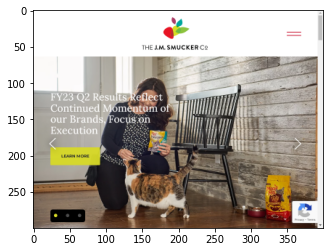

In [64]:
plt.imshow(X_image[1947]), X_text[1947], y[1947]

# Proproccess Text

In [66]:
sample_merged_key_df = merged_key_df.sample(frac=0.1)

In [67]:
sample_merged_key_df

,url,num_of_picture,text,target
334,http://www.farmersnationalbank.com/,363,skip to contentrouting 071108423searchmenupe...,0
2623,https://www.taylorlivestockfarm.co.za,683,skip to contentmain menuwelcome totaylor lives...,1
502,http://www.peoples.com/peoples,556,skip to main contentpersonal customers\tperson...,0
960,http://www.ca-cib.com/,1049,skip to main contentslide de la home page en n...,0
2903,https://cavoodlepuppiesforsale.business.site,970,cavoodle puppies for saleget quotecall nowg...,1
...,...,...,...,...
3142,http://www.profitableearnings.com,1213,16965 9 0 3 1269 57 0 3 0 99818 0 3 0 ...,1
3704,https://cryptopreco.com/,1814,server time thursday december 1 6 22 pm e ma...,1
2103,https://www.asahaldistribution.com,130,menucategorieshomelatest productsall productsf...,1
1912,http://www.americantower.com/,2017,about cookies on this sitewe use cookies to co...,0


# Sequential Model

In [14]:
# Architecture

def create_model(use_vgg=False):
    if not use_vgg:
        model = models.Sequential([
            layers.Conv2D(16, (4, 4), activation='relu', input_shape=X.shape[1:]),
            layers.MaxPool2D(2, 2),
            layers.BatchNormalization(),

            layers.Conv2D(16, (4, 4), activation='relu'),
            layers.MaxPool2D(2, 2),
            layers.BatchNormalization(),

            layers.Conv2D(16, (4, 4), activation='relu'),
            layers.MaxPool2D(2, 2),
            layers.BatchNormalization(),

            # layers.Conv2D(64, (2, 2), activation='relu'),
            # layers.MaxPool2D(2, 2),
            # layers.BatchNormalization(),

            layers.Flatten(),

            layers.Dense(64, activation='relu'),
            # layers.Dropout(0.7),
            layers.Dense(32, activation='relu'),
            # layers.Dropout(0.7),
            layers.Dense(16, activation='relu'),
            # layers.Dropout(0.7),

            layers.Dense(1, activation='sigmoid')
        ])
    else:
        vgg_model = vgg19.VGG19(include_top=False, input_shape=X.shape[1:])
        vgg_model.trainable = False
        
        model = models.Sequential([
            vgg_model,
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
    
    return model

def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [15]:
model = create_model()
model = compile_model(model)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 397, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 198, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 148, 198, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 195, 16)      4112      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 97, 16)       0         
 2D)                                                             
                                                        

In [ ]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X,
    y,
    epochs=50,
    validation_split=0.3,
    batch_size=16,
    callbacks=[es]
)

2022-12-05 12:47:16.921506: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4273920000 exceeds 10% of free system memory.


Epoch 1/50
186/186 [==============================] - ETA: 0s - loss: 0.8968 - accuracy: 0.5482

2022-12-05 12:49:02.181115: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1833120000 exceeds 10% of free system memory.


186/186 [==============================] - 106s 564ms/step - loss: 0.8968 - accuracy: 0.5482 - val_loss: 0.7610 - val_accuracy: 0.5255
Epoch 2/50
186/186 [==============================] - 95s 512ms/step - loss: 0.7089 - accuracy: 0.6034 - val_loss: 0.7109 - val_accuracy: 0.5232
Epoch 3/50
186/186 [==============================] - 98s 529ms/step - loss: 0.6822 - accuracy: 0.6001 - val_loss: 1.0548 - val_accuracy: 0.5302
Epoch 4/50
186/186 [==============================] - 97s 524ms/step - loss: 0.6714 - accuracy: 0.6223 - val_loss: 0.6841 - val_accuracy: 0.6017
Epoch 5/50
186/186 [==============================] - 99s 534ms/step - loss: 0.6236 - accuracy: 0.6594 - val_loss: 0.6689 - val_accuracy: 0.5719
Epoch 6/50
186/186 [==============================] - 100s 539ms/step - loss: 0.5674 - accuracy: 0.7072 - val_loss: 0.8909 - val_accuracy: 0.5271
Epoch 7/50
186/186 [==============================] - 99s 531ms/step - loss: 0.4957 - accuracy: 0.7672 - val_loss: 0.7175 - val_accuracy: 0

# Functional Model

In [ ]:
from tensorflow.keras import layers, models, callbacks, Model

# CNN Architecture
cnn_input = layers.Input(shape=X.shape[1:])

x = layers.Conv2D(16, (4, 4), activation='relu')(cnn_input)
x = layers.MaxPool2D(2, 2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(16, (4, 4), activation='relu')(x)
x = layers.MaxPool2D(2, 2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(16, (4, 4), activation='relu')(x)
x = layers.MaxPool2D(2, 2)(x)
x = layers.BatchNormalization()(x)

cnn_output = layers.Flatten()(x)

In [ ]:
# Define NLP Architecture here

In [ ]:
# Define NLP model and concatenate output
combined = layers.concatenate([cnn_output, nlp_output])

z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)

final_output = layers.Dense(1, activation='sigmoid')(z)

model = Model(cnn_input, output)

In [ ]:
model.summary()

In [ ]:
model = compile_model(model)

history = model.fit(
    X,
    y,
    epochs=25,
    batch_size=16,
    validation_split=0.3,
    callbacks=callbacks.EarlyStopping(patience=10, restore_best_weights=True)
)